# Neural Network

In [1]:
# Compile C source codes
!gcc -Wall MonteCarloSampling.c -o MonteCarloSampling.o -lm

In [2]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(rc={'figure.figsize':(22,6)}, style='darkgrid')

import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"\nUsing {device} device")

# CONSTANTS
critical_temperature = 2/( np.log( np.sqrt(2)+1) )

# FUNCTIONS
def generate_data(lowest_temperature, increment_temperature, highest_temperature,
                  lattice_side, number_of_configurations,
                  initial_number_of_thermalisation_steps, number_of_thermalisation_steps,
                  filename='data.csv', clear_old_data=True, show_termalisation_info=False):
  # ! This version supports the "initial_number_of_thermalisation_steps" parameter
  debug_flag = "" if show_termalisation_info else "1>/dev/null"
  clear_flag = f"rm -rf {filename}" if clear_old_data else ""

  sh = f"""
  set -e
  export LC_NUMERIC="en_US.UTF-8"

  {clear_flag}

  for T in $(seq {lowest_temperature} {increment_temperature} {highest_temperature})
  do
    ./MonteCarloSampling.o --lattice-side {lattice_side} \
                          --temperature $T \
                          --number-of-configurations {number_of_configurations} \
                          --initial_thermalisation-steps {initial_number_of_thermalisation_steps} \
                          --thermalisation-steps {number_of_thermalisation_steps} \
                          --output-file '{filename}' {debug_flag}
  done
  """
  with open('script.sh', 'w') as file:
    file.write(sh)

  !bash script.sh && rm script.sh

def dataframe_from_lattice_csv(fileName, lattice_side):
  df = pd.read_csv(fileName, names=['L', 'T', 'E']+['LP'+str(i) for i in range(lattice_side*lattice_side)] )

  df['lattice'] = df[df.columns[3:]].apply( lambda x: np.array(x, dtype=np.float32), axis=1)
  df = df.drop(columns=['L']+['LP'+str(i) for i in range(lattice_side*lattice_side)])
  df['magnetization']  = df['lattice'].apply(lambda x: x.sum()/x.shape[0])

  return df



Using cpu device


Data Generation

In [3]:
lowest_temperature = 1
highest_temperature = 3.51
increment_temperature = 0.05
lattice_side = 30
number_of_configurations = 1000
initial_number_of_thermalisation_steps = 2000
number_of_thermalisation_steps = 1000
# number_of_thermalisation_steps = 4000

filename = "FCNN_data.csv"
# generate_data(lowest_temperature, increment_temperature, highest_temperature,
#               lattice_side, number_of_configurations,
#               initial_number_of_thermalisation_steps, number_of_thermalisation_steps,
#               filename, clear_old_data=True, show_termalisation_info=False)

print(f"Data Generation completed. The files are available in {filename}.")

Data Generation completed. The files are available in FCNN_data.csv.


In [4]:
from sklearn.model_selection import train_test_split

df = dataframe_from_lattice_csv(filename, lattice_side)

# Input data are just the lattice sites
X = np.empty( (df['lattice'].shape[0], lattice_side*lattice_side), dtype=np.float32 )
for idx, lattice in enumerate(df['lattice']):
  X[idx] = lattice

# Y should be [0., 1.] if T>Tc or [1., 0] otherwise.
Y = np.empty( (df.shape[0], 2), dtype=np.float32)
for idx, T in enumerate(df['T']):
  Y[idx] = [0., 1.] if T>critical_temperature else [1., 0]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, shuffle=True)

Nine configurations with their label picked at random.

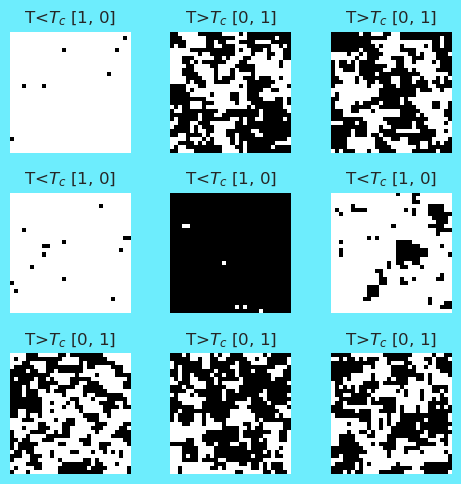

In [5]:

fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(5, 5))
fig.patch.set_facecolor('xkcd:robin\'s egg')

# Flatten the axs array for easy iteration
axs = axs.flatten()

for ax in axs:
    sample_idx = int(np.random.rand()*len(X_train))
    img, label = X_train[sample_idx], Y_train[sample_idx, :]
    ax.set_title(r"T{}$T_c$ [{}, {}]".format('>' if label[1] else '<',
                                            int(label[0]),
                                            int(label[1]) ))
    ax.axis("off")
    ax.imshow(img.reshape((lattice_side, lattice_side)), interpolation='none',
              cmap="gray")

plt.tight_layout()
plt.show();

In [6]:
from torch import nn

class NeuralNetwork(nn.Module):  
  def __init__(self):
    super(NeuralNetwork, self).__init__()

    self.layers = nn.Sequential(
      nn.Linear(lattice_side*lattice_side, 100, bias=True),
      nn.Sigmoid(),
      nn.Linear(100, 2, bias=False),
      nn.Sigmoid()
    )

  def forward(self, x):
    return self.layers(x)

  
  def predict(self, x):
    output = self.forward(x)
    return torch.argmax(output, 1)

#####################################


def train(model, X, y, epochs):
  # The Cross Entropy Loss is suitable for classification problems
  loss_function = nn.BCELoss()

  # Create an optimizer that will be used to train the network.
  # Weight decay handles the L2 regularizator
  learning_rate = 1e-2
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=2e-05)
  
  # List of losses for visualization
  losses = []

  for i in range(epochs):
    y_pred = model.forward(X)
    loss = loss_function(y_pred, y)

    # Clear the previous gradient and compute the new one
    optimizer.zero_grad()
    loss.backward()

    # Adapt the weights of the network
    optimizer.step()

    # Store the loss
    losses.append(loss.item())

  return losses

Results of the upgraded network

Test loss: 0.03747265040874481 



/tmp/ipykernel_588396/3830070116.py:31: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(x=df['T'], y=Y_detached[:, 0], ax=axs[1], label=r"output[0]", marker="o", ci=None)
/home/david/anaconda3/envs/ds/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/david/anaconda3/envs/ds/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/david/anaconda3/envs/ds/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instea

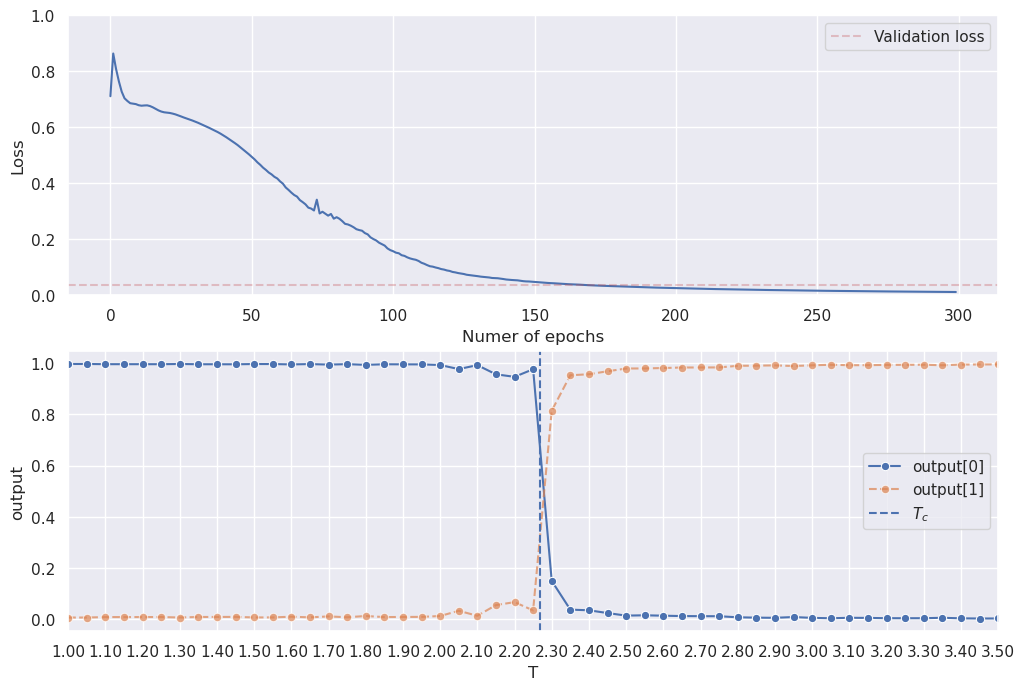

In [7]:
# Convert the 2D points to a float32 tensor
X_train_torch = torch.tensor(X_train, dtype=torch.float32).to(device)
Y_train_torch = torch.from_numpy(Y_train).to(device)
X_test_torch = torch.tensor(X_test, dtype=torch.float32).to(device)
Y_test_torch = torch.from_numpy(Y_test).to(device)

# Generate and train the model
model = NeuralNetwork().to(device)
losses = train(model, X_train_torch, Y_train_torch, epochs=300)

# Test the model
Y_pred = model.forward(X_test_torch)
loss = nn.BCELoss()(Y_pred, Y_test_torch)
print("Test loss:", loss.item(), "\n")


# Plots
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(12, 8))
axs[0].plot(np.arange( len(losses) ), losses);
axs[0].axhline(y=loss.item(), color='r', linestyle='--', alpha=0.3, label="Validation loss")
axs[0].legend()
axs[0].set_ylim([0, 1])
axs[0].set_ylabel("Loss")
axs[0].set_xlabel("Numer of epochs");


X_torch = torch.tensor(X, dtype=torch.float32).to(device)
Y_pred = model.forward(X_torch)
Y_detached = Y_pred.cpu().detach().numpy()

sns.lineplot(x=df['T'], y=Y_detached[:, 0], ax=axs[1], label=r"output[0]", marker="o", ci=None)
sns.lineplot(x=df['T'], y=Y_detached[:, 1], ax=axs[1], label=r"output[1]", marker="o", ci=None, alpha=0.7, linestyle='--')
axs[1].axvline(critical_temperature, 0, 1, label=r"$T_c$", linestyle="--")

xticks = np.arange(lowest_temperature, highest_temperature, 2*increment_temperature)
axs[1].set_xticks(xticks)
axs[1].set_xticklabels(['{:.2f}'.format(T) for T in xticks])
axs[1].legend()
axs[1].set_xlim([1, 3.5])
axs[1].set_ylabel("output");